# Understanding Customer Spending: A Data-Driven Credit Card Behavior Analysis

## 1. Model Overview

In this section, we will explore the clustering model used in our analysis. We will review key insights from the exploratory data analysis (EDA), including important KPIs and findings from the PCA (Principal Component Analysis). 

We will implement two clustering algorithms: **K-means** and **Hierarchical Clustering**, and determine the optimal number of clusters by comparing **silhouette scores** across different cluster numbers. Additionally, we will perform profiling on the resulting clusters to ensure meaningful segmentation.

The main objectives of this section are:
- Segment customers into distinct groups based on their credit card usage behaviors.
- Identify the key characteristics of each cluster through detailed behavioral profiling.
- Provide strategic recommendations for targeted marketing initiatives based on the clustering results.


## 2. Importing libraries

In [1]:
import pickle
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from scipy.spatial.distance import pdist
from yellowbrick.cluster import SilhouetteVisualizer

## 3. Load auxiliary functions

In [2]:
def calculate_cophenetic_distances(pca_data, linkage_methods, distance_metrics):
    """
    Calculate the cophenetic distance correlation coefficient for various linkage methods 
    and distance metrics, including Ward's linkage.

    Parameters:
    - pca_data: PCA-transformed data (numpy array or DataFrame)
    - linkage_methods: List of linkage methods to evaluate (e.g., ['single', 'complete', 'average'])
    - distance_metrics: List of distance metrics to evaluate (e.g., ['euclidean', 'cityblock', 'cosine'])

    Returns:
    - results: Dictionary containing cophenetic correlation coefficients for each method-metric combination
    """
    results = {}

    for method in linkage_methods:
        print(f"\nLinkage Method: {method}")
        results[method] = {}
        
        for metric in distance_metrics:
            Z = linkage(pca_data, method=method, metric=metric)
            c, _ = cophenet(Z, pdist(pca_data, metric=metric))
            results[method][metric] = c
            print(f"Cophenetic Correlation (Metric: {metric}): {c:.4f}")
    
    # Ward's linkage (default distance metric is Euclidean)
    Z_ward = linkage(pca_data, method='ward')
    c_ward, _ = cophenet(Z_ward, pdist(pca_data))
    results['ward'] = {'euclidean': c_ward}
    print(f"\nCophenetic Correlation for Ward's Linkage (Euclidean Distance): {c_ward:.4f}")
    
    return results

In [3]:
def find_optimal_clusters(X, cluster_range, kmeans_init='k-means++', n_init=100, agg_linkage='average', agg_affinity='cityblock'):
    """
    Calculate the optimal number of clusters using K-Means and Agglomerative Clustering, 
    including silhouette scores and inertia (WCSS) for K-Means.
    
    Parameters:
    - X: Data (numpy array or DataFrame)
    - cluster_range: Range of cluster numbers to evaluate (e.g., (3, 9))
    - kmeans_init: Initialization method for K-Means (default: 'k-means++')
    - n_init: Number of initializations for K-Means (default: 100)
    - agg_linkage: Linkage method for Agglomerative Clustering (default: 'average')
    - agg_affinity: Affinity (distance metric) for Agglomerative Clustering (default: 'cityblock')
    
    Returns:
    - results: Dictionary containing WCSS and silhouette scores for K-Means and Agglomerative Clustering
    """
    results = {
        'wcss': [],
        'sil_kmeans': [],
        'sil_agc': []
    }

    for i in range(cluster_range[0], cluster_range[1]):
        print(f"\nNumber of Clusters: {i}")
        
        # K-Means Clustering
        kmeans = KMeans(n_clusters=i, n_init=n_init, init=kmeans_init, random_state=0)
        kmeans.fit(X)
        
        # Inertia (WCSS) and Silhouette Score for K-Means
        in_km = kmeans.inertia_
        results['wcss'].append(in_km)
        sil_km = silhouette_score(X, kmeans.labels_)
        results['sil_kmeans'].append(sil_km)
        print(f"K-Means Inertia (WCSS): {in_km}")
        print(f"Silhouette Score for K-Means: {sil_km:.4f}")
        
        # Agglomerative Clustering
        agc = AgglomerativeClustering(n_clusters=i, linkage=agg_linkage, metric=agg_affinity)
        agc.fit(X)
        sil_ag = silhouette_score(X, agc.labels_)
        results['sil_agc'].append(sil_ag)
        print(f"Silhouette Score for Agglomerative Clustering: {sil_ag:.4f}")
    
    return results

In [4]:
def compute_wcss_and_silhouette(data, cluster_range):
    """
    Computes WCSS and Silhouette Scores for K-Means and Agglomerative Clustering.
    
    Parameters:
    - data: The input data for clustering.
    - cluster_range: The range of cluster numbers to test.
    
    Returns:
    - wcss: List of WCSS values for K-Means.
    - sil_kmeans: List of silhouette scores for K-Means clustering.
    - sil_agc: List of silhouette scores for Agglomerative Clustering.
    """
    wcss = []
    sil_kmeans = []
    sil_agc = []
    
    for k in cluster_range:
        # K-Means
        kmeans = KMeans(n_clusters=k, n_init=100, random_state=0)
        y_kmeans = kmeans.fit_predict(data)
        wcss.append(kmeans.inertia_)
        sil_kmeans.append(silhouette_score(data, y_kmeans))
        
        # Agglomerative Clustering
        agc = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
        y_agc = agc.fit_predict(data)
        sil_agc.append(silhouette_score(data, y_agc))
    
    return wcss, sil_kmeans, sil_agc

In [5]:
def plot_elbow_and_silhouette(wcss, sil_kmeans, sil_agc, save_path=None):
    """
    Plot the elbow curve for determining the optimal number of clusters,
    along with silhouette scores for K-Means and Agglomerative Clustering.

    Parameters:
    - wcss: List of WCSS values for different numbers of clusters.
    - sil_kmeans: List of silhouette scores for K-Means clustering.
    - sil_agc: List of silhouette scores for Agglomerative Clustering.
    - save_path: Optional path to save the figure.
    """
    # Elbow Plot
    plt.figure(figsize=(16, 12))

    plt.subplot(3, 1, 1)
    plt.plot(range(3, len(wcss) + 3), wcss, color='#800000', marker='o')
    plt.title('Elbow Method', fontsize=16)
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Cluster Errors (WCSS)', fontsize=14)
    plt.xticks(range(3, len(wcss) + 3))
    plt.grid(True)

    # Silhouette Scores for K-Means
    plt.subplot(3, 1, 2)
    plt.plot(range(3, len(sil_kmeans) + 3), sil_kmeans, marker='s', color='purple')
    plt.title('Silhouette Scores for K-Means Clustering', fontsize=16)
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Silhouette Score', fontsize=14)
    plt.xticks(range(3, len(sil_kmeans) + 3))
    plt.grid(True)

    # Silhouette Scores for Agglomerative Clustering
    plt.subplot(3, 1, 3)
    plt.plot(range(3, len(sil_agc) + 3), sil_agc, marker='s', color='green')
    plt.title('Silhouette Scores for Agglomerative Clustering', fontsize=16)
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Silhouette Score', fontsize=14)
    plt.xticks(range(3, len(sil_agc) + 3))
    plt.grid(True)

    plt.tight_layout()

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()  # Always show the plot

    plt.close()  # Close the figure to free up memory

In [6]:
def plot_silhouette(X, cluster_range, save_path=None, n_init=100, random_state=0):
    """
    Plot silhouette visualizations for K-Means clustering across a range of clusters.

    Parameters:
    - X: Data (numpy array or DataFrame)
    - cluster_range: Range of cluster numbers to evaluate (e.g., (3, 9))
    - save_path: Optional path to save the figure.
    - n_init: Number of initializations for K-Means (default: 100)
    - random_state: Random seed for reproducibility (default: 0)
    """
    fig, axs = plt.subplots(2, 3, figsize=(20, 15))
    axs = axs.flatten() 

    for i, k in enumerate(range(cluster_range[0], cluster_range[1])):
        ax = axs[i]
        sil = SilhouetteVisualizer(KMeans(n_clusters=k, n_init=n_init, init='k-means++', random_state=random_state), ax=ax)
        sil.fit(X)
        sil.finalize()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save the figure if a path is provided

    plt.show()  # Always show the plot

    plt.close()  # Close the figure to free up memory

In [7]:
def plot_dendrogram(data, method='average', metric='euclidean', truncate_level=9, figsize=(14, 10), save_path=None):
    """
    Plot a dendrogram for agglomerative hierarchical clustering.

    Parameters:
    - data: DataFrame or array-like object to cluster.
    - method: Linkage method (default is 'average').
    - metric: Distance metric (default is 'euclidean').
    - truncate_level: Level of truncation for the dendrogram (default is 9).
    - figsize: Size of the figure (default is (14, 10)).
    - save_path: Optional path to save the figure.
    """
    Z = linkage(data, method=method, metric=metric)
    
    plt.figure(figsize=figsize)
    plt.title('Agglomerative Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    dendrogram(Z, leaf_rotation=90, leaf_font_size=8, truncate_mode='level', p=truncate_level)
    plt.tight_layout()

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()  # Always show the plot
    plt.close()  # Close the figure to free up memory

In [8]:
def plot_kmeans_clusters(X, n_clusters=3, n_init=100, save_path=None):
    """
    Apply K-Means clustering and visualize the spread of the data in a 3x2 grid.

    Parameters:
    - X: Data to cluster (numpy array or DataFrame).
    - n_clusters: Number of clusters for K-Means (default is 3).
    - n_init: Number of initializations for K-Means (default is 100).
    - save_path: Optional path to save the figure.
    """

    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, init='k-means++', random_state=0)
    kmeans.fit(X)

    df_pca = pd.DataFrame(X)
    df_pca['Cluster'] = kmeans.labels_

    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.flatten()  

    for i in range(6):
        # Check to avoid index error for the last scatter plot
        if i + 1 < df_pca.shape[1]:  
            sns.scatterplot(x=df_pca[i], y=df_pca[i + 1], hue=df_pca['Cluster'], palette='Set2', ax=axs[i])
            axs[i].set_title(f'Scatter Plot of Principal Components {i} and {i + 1}', fontsize=14)
            axs[i].set_xlabel(f'Principal Component {i}', fontsize=12)
            axs[i].set_ylabel(f'Principal Component {i + 1}', fontsize=12)
            axs[i].legend(title='Cluster', loc='best', fontsize=10)

    plt.tight_layout()
    
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()  # Always show the plot
    plt.close()  # Close the figure to free up memory


In [9]:
def segment_distribution(X, original_df, min_clusters=3, max_clusters=8, n_init=100):
    """
    Perform K-Means clustering for a range of cluster sizes and append cluster labels to the original DataFrame.

    Parameters:
    - X: Data to cluster (numpy array or DataFrame).
    - original_df: Original DataFrame to which cluster labels will be appended.
    - min_clusters: Minimum number of clusters (default is 3).
    - max_clusters: Maximum number of clusters (default is 8).
    - n_init: Number of initializations for K-Means (default is 100).

    Returns:
    - updated_df: DataFrame containing original variables and cluster labels for each cluster size.
    """
    updated_df = original_df.copy()

    for n_clusters in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, init='k-means++', random_state=0)
        cluster_labels = kmeans.fit_predict(X)
        updated_df[f'Cluster_{n_clusters}'] = cluster_labels

    return updated_df



In [10]:
def calculate_segment_distribution(updated_df, target_clusters):
    """
    Calculate the segment distribution for the specified target cluster size.

    Parameters:
    - updated_df: DataFrame containing cluster labels.
    - target_clusters: Number of clusters for which to return the segment distribution.

    Returns:
    - None
    """
    if f'Cluster_{target_clusters}' in updated_df.columns:
        segment_distribution = (
            pd.Series.sort_index(updated_df[f'Cluster_{target_clusters}'].value_counts())
            / sum(updated_df[f'Cluster_{target_clusters}'].value_counts())
        )
        print(f"Segment Distribution for cluster K={target_clusters}:\n", segment_distribution)
    else:
        print(f"Target cluster size {target_clusters} does not exist in the DataFrame.")

## 4. Loading the data 

In [11]:
file_path = os.path.join('..', 'results', 'EDA_results', 'X_PCA_7.pkl')

# Load the pickle file
with open(file_path, 'rb') as f:
    X_PCA_7 = pickle.load(f)

In [12]:
ML_df = pd.read_csv('../results/EDA_results/ML_df.csv')

In [13]:
original_df = pd.read_csv('../results/EDA_results/original_df_DM.csv')

In [14]:
linkage_methods = ['single', 'complete', 'average']
distance_metrics = ['euclidean', 'cityblock', 'cosine']

cophenetic_results = calculate_cophenetic_distances(X_PCA_7, linkage_methods, distance_metrics)


Linkage Method: single
Cophenetic Correlation (Metric: euclidean): 0.8054
Cophenetic Correlation (Metric: cityblock): 0.8079
Cophenetic Correlation (Metric: cosine): 0.0558

Linkage Method: complete
Cophenetic Correlation (Metric: euclidean): 0.7557
Cophenetic Correlation (Metric: cityblock): 0.7616
Cophenetic Correlation (Metric: cosine): 0.4585

Linkage Method: average
Cophenetic Correlation (Metric: euclidean): 0.8855
Cophenetic Correlation (Metric: cityblock): 0.8652
Cophenetic Correlation (Metric: cosine): 0.6121

Cophenetic Correlation for Ward's Linkage (Euclidean Distance): 0.4392


The cophenetic distance correlation coefficient is a valuable metric in evaluating the accuracy of different linkage methods in hierarchical clustering. For our Agglomerative Clustering algorithm, this coefficient helps us determine which linkage method best preserves the original pairwise distances in the dataset. Based on the output of our analysis, the **Average Linkage Method** combined with **Euclidean Distances** provides the highest cophenetic correlation, making it the most reliable choice for clustering in this particular dataset.


## 5.1 Finding the optimal number of clusters for K-Means and Agglomerative Clustering

### 5.1. Inference through Elbow Method and Silhouette Score 

In [15]:
cluster_range = (3, 9)
optimal_clusters_results = find_optimal_clusters(X_PCA_7, cluster_range)


Number of Clusters: 3
K-Means Inertia (WCSS): 99397.83554877559
Silhouette Score for K-Means: 0.2980
Silhouette Score for Agglomerative Clustering: 0.8689

Number of Clusters: 4
K-Means Inertia (WCSS): 84676.22005514555
Silhouette Score for K-Means: 0.2516
Silhouette Score for Agglomerative Clustering: 0.8205

Number of Clusters: 5
K-Means Inertia (WCSS): 75906.79619660012
Silhouette Score for K-Means: 0.2444
Silhouette Score for Agglomerative Clustering: 0.8200

Number of Clusters: 6
K-Means Inertia (WCSS): 68360.00382644712
Silhouette Score for K-Means: 0.2423
Silhouette Score for Agglomerative Clustering: 0.8057

Number of Clusters: 7
K-Means Inertia (WCSS): 61384.41071751411
Silhouette Score for K-Means: 0.2395
Silhouette Score for Agglomerative Clustering: 0.7725

Number of Clusters: 8
K-Means Inertia (WCSS): 56760.102241596345
Silhouette Score for K-Means: 0.2423
Silhouette Score for Agglomerative Clustering: 0.7557


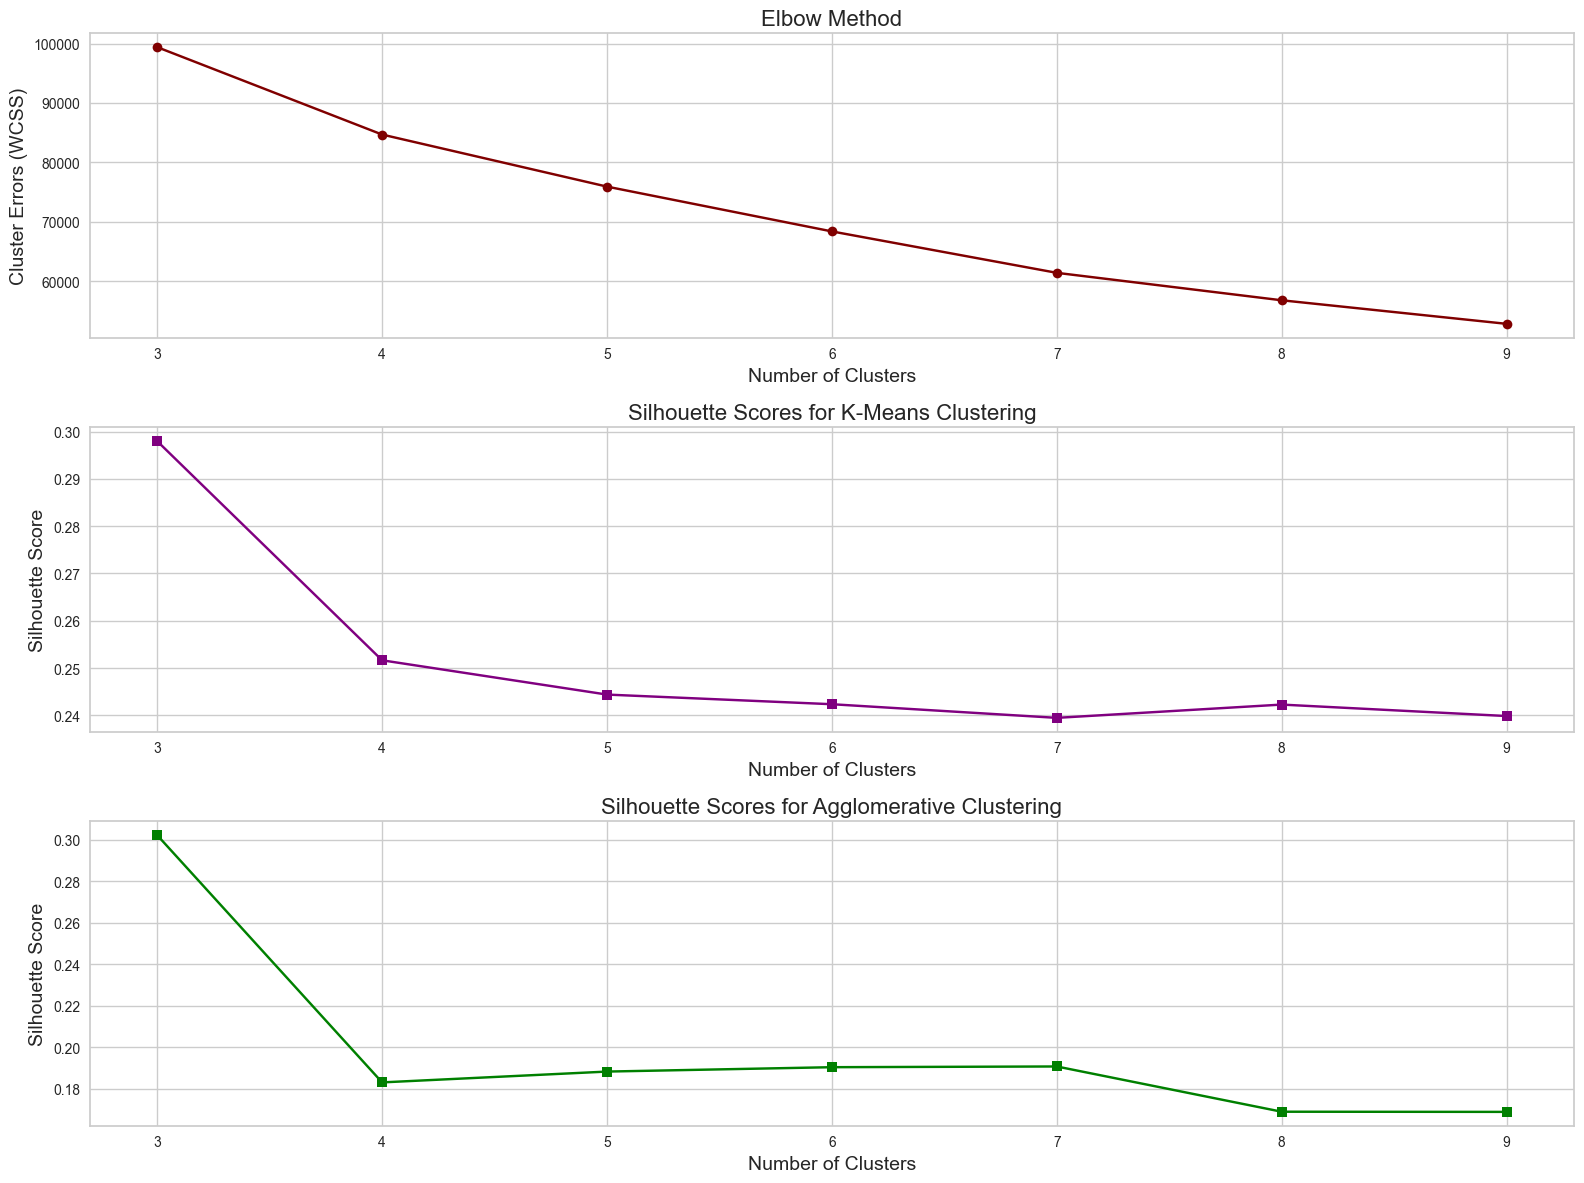

In [16]:
cluster_range = range(3, 10)
wcss, sil_kmeans, sil_agc = compute_wcss_and_silhouette(X_PCA_7, cluster_range)

figures_output_dir = "../results/ML_results/figures"
os.makedirs(figures_output_dir, exist_ok=True) 
plot_path = os.path.join(figures_output_dir, 'elbow_silhouette_plot.png')

# Call the plotting function and save the plot
plot_elbow_and_silhouette(wcss, sil_kmeans, sil_agc, save_path=plot_path)

### 5.2. Inference through silhouette plotting

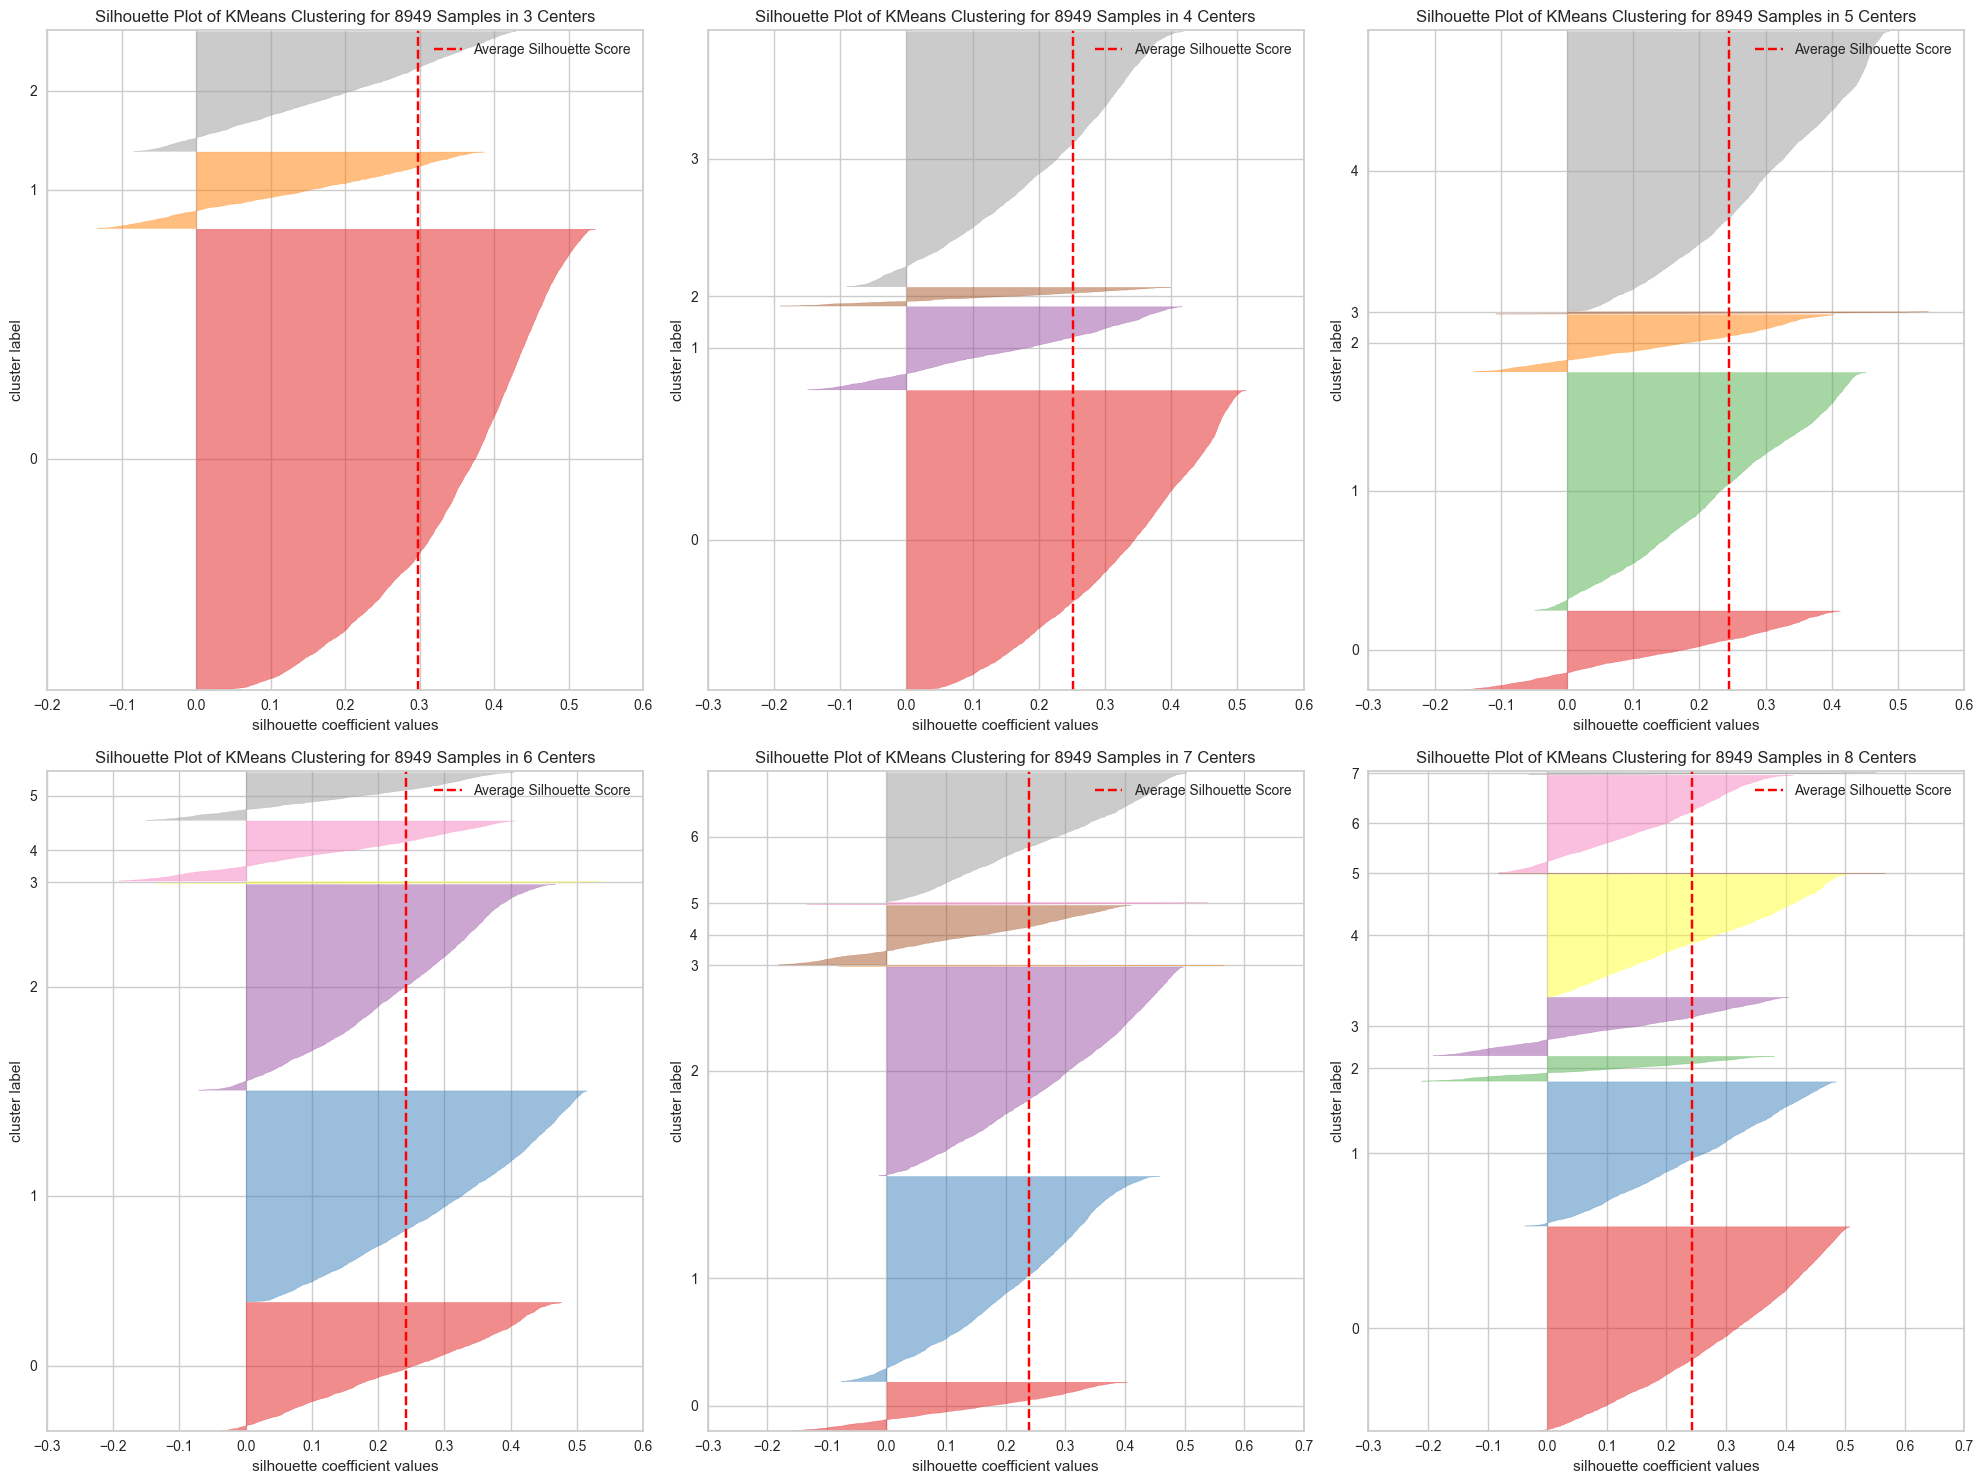

In [17]:
figures_output_dir = "../results/ML_results/figures"
os.makedirs(figures_output_dir, exist_ok=True) 
plot_path = os.path.join(figures_output_dir, 'silhouette_plots.png')

# Call the plotting function to save and show the silhouette plots
plot_silhouette(X_PCA_7, (3, 9), save_path=plot_path)

### 5.3. Dendogram of Agglomerative Clustering

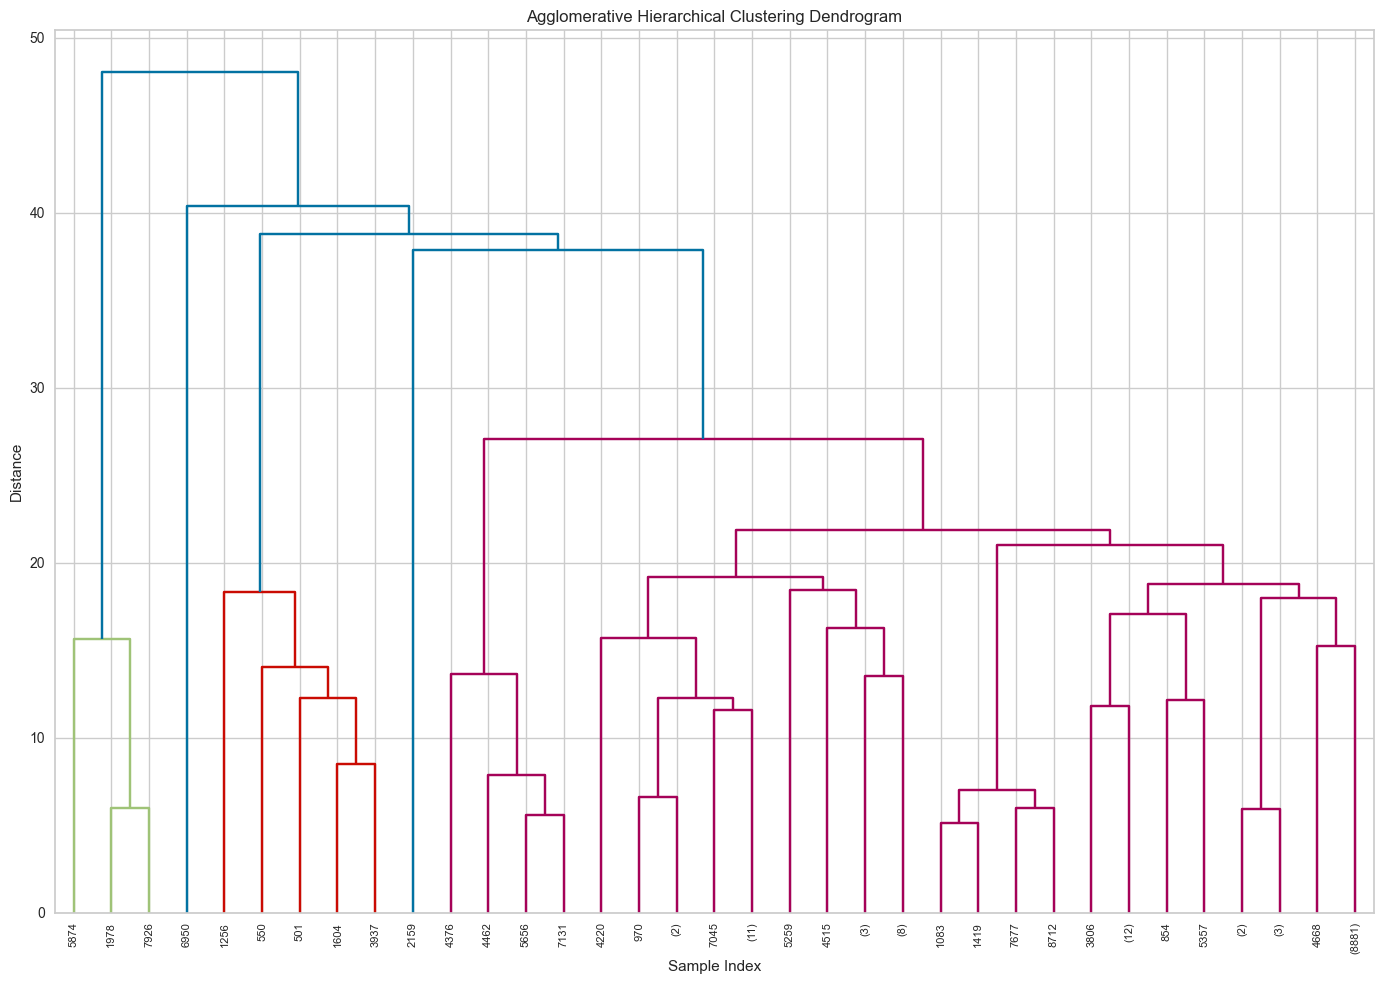

In [18]:
figures_output_dir = "../results/ML_results/figures"
os.makedirs(figures_output_dir, exist_ok=True)  # Create directory if it doesn't exist
dendrogram_path = os.path.join(figures_output_dir, 'dendrogram_plot.png')

# Call the plotting function to save and show the dendrogram
plot_dendrogram(ML_df, save_path=dendrogram_path)

### 5.4. Cluster Visualization 

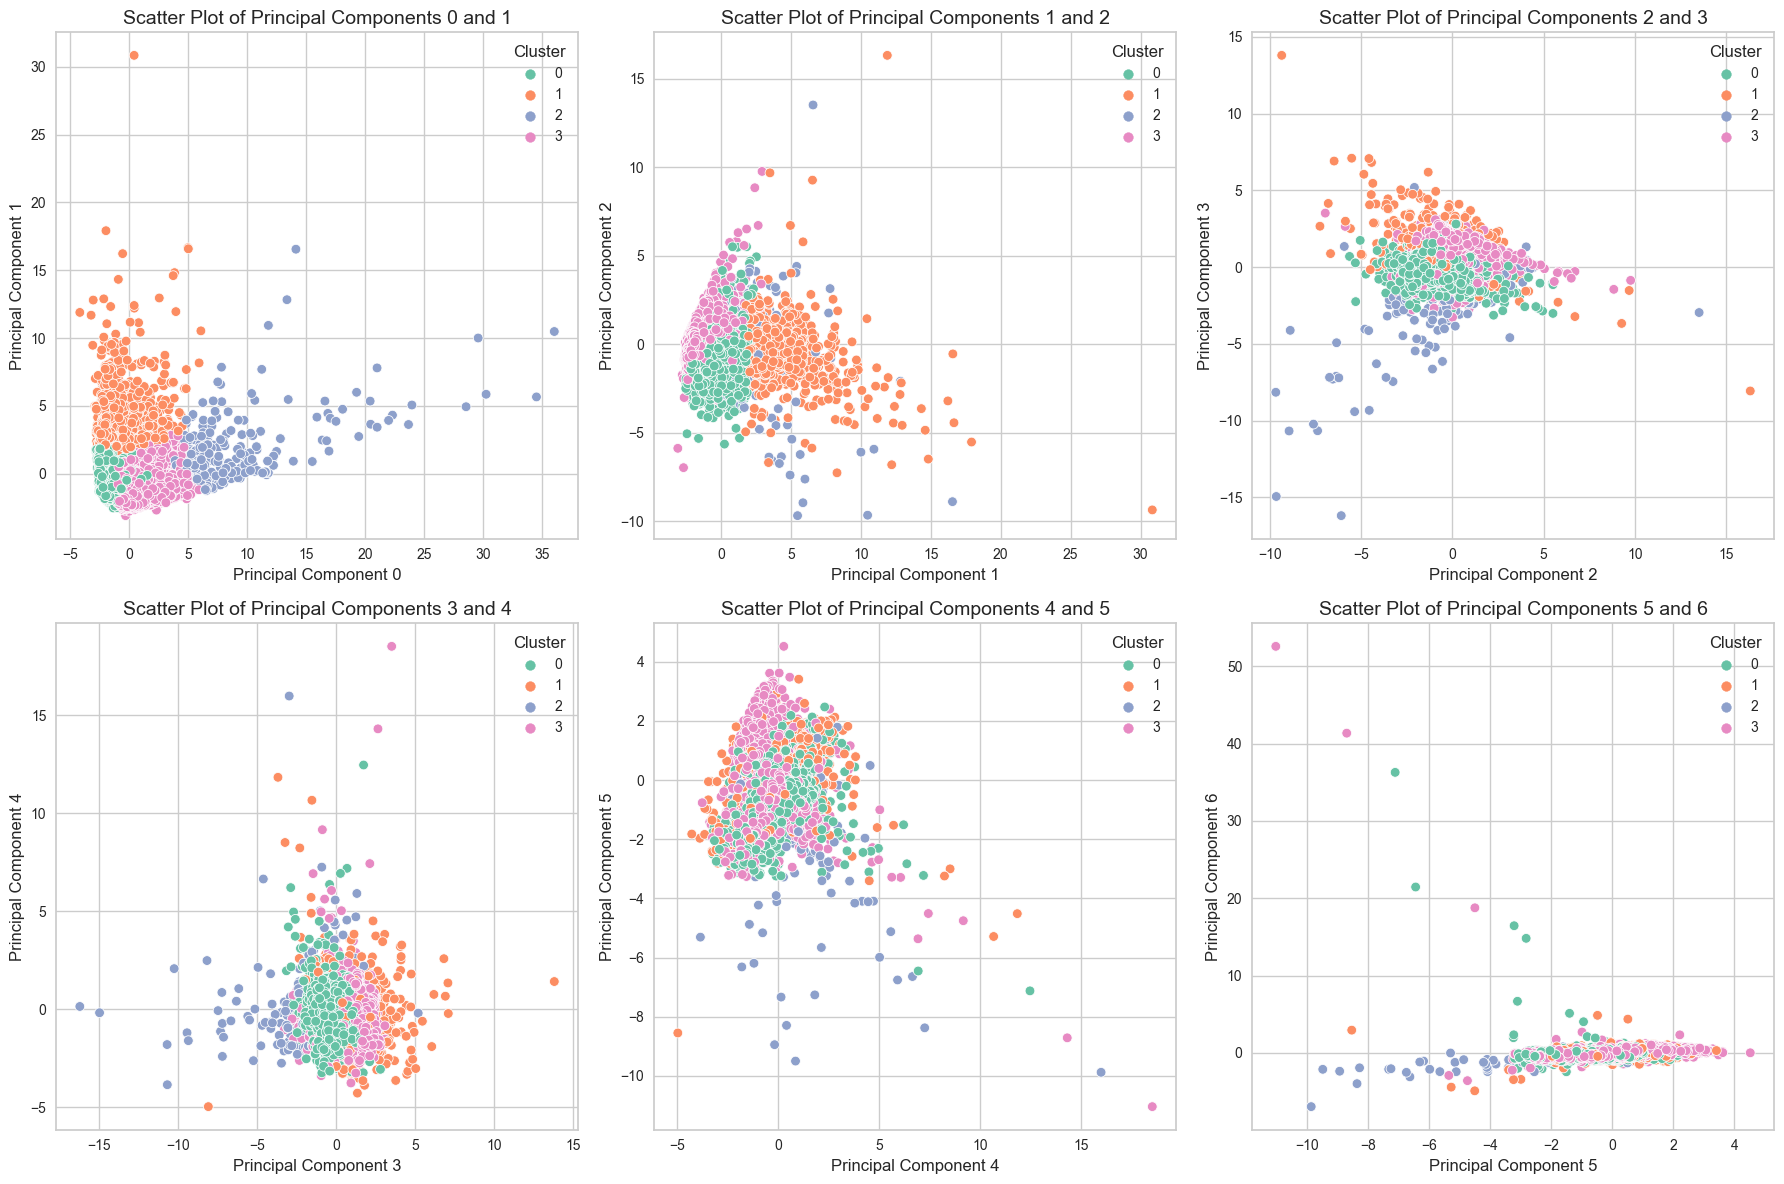

In [19]:
figures_output_dir = "../results/ML_results/figures"
os.makedirs(figures_output_dir, exist_ok=True)  
kmeans_plot_path = os.path.join(figures_output_dir, 'kmeans_clusters4_plot.png')

# Call the plotting function to save and show the K-Means clusters
plot_kmeans_clusters(X_PCA_7, n_clusters=4, save_path=kmeans_plot_path)

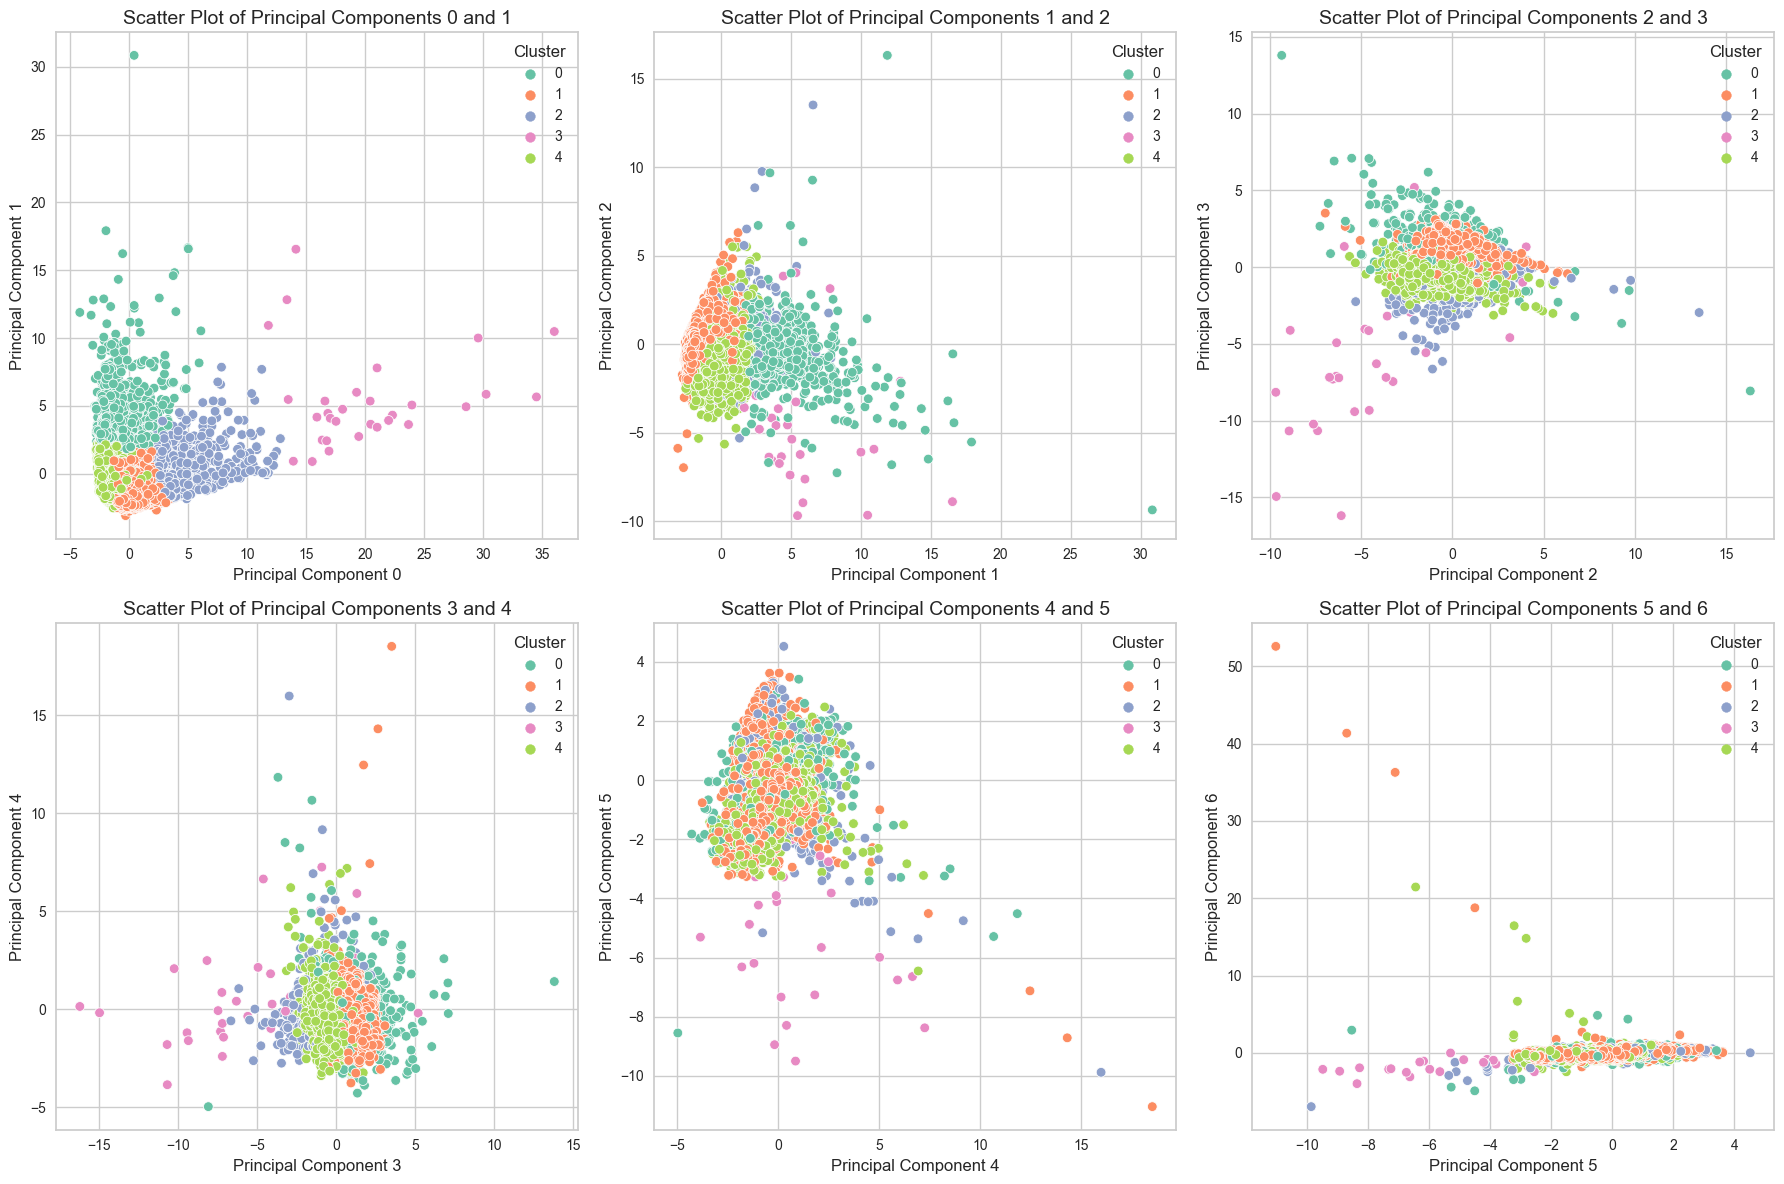

In [20]:
figures_output_dir = "../results/ML_results/figures"
os.makedirs(figures_output_dir, exist_ok=True)  
kmeans_plot_path = os.path.join(figures_output_dir, 'kmeans_clusters5_plot.png')

# Call the plotting function to save and show the K-Means clusters
plot_kmeans_clusters(X_PCA_7, n_clusters=5, save_path=kmeans_plot_path)

### 5.5. Segment Distribution Analysis

In [21]:
# Using the segment distribution function to calculate the segment distribution 
#within our original dataset with the dummies
original_df_CL = segment_distribution(X_PCA_7, original_df)

In [22]:
original_df_CL.head()

,Installment_Purchases,None_Of_the_Purchases,One_Of_Purchase,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,...,MONTHLY_AVG_PURCHASES,AVG_CASH_ADVANCE,Limit_Usage,Pay_to_MinimumPay,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8
0,1,0,0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,...,7.950000,0.000000,0.040901,1.446508,0,0,4,0,6,4
1,0,1,0,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,...,0.000000,536.912124,0.457495,3.826241,2,1,0,4,4,3
2,0,0,1,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,...,64.430833,0.000000,0.332687,0.991682,0,3,1,2,1,6
3,0,0,1,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,...,124.916667,17.149001,0.222223,0.000000,0,0,4,0,6,4
4,0,0,1,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,...,1.333333,0.000000,0.681429,2.771075,0,0,4,1,2,0


In [23]:
#Segment distribution for k = 4
calculate_segment_distribution(original_df_CL, target_clusters=4)


Segment Distribution for cluster K=4:
 Cluster_4
0    0.455917
1    0.126718
2    0.028383
3    0.388982
Name: count, dtype: float64


In [24]:
#Segment distribution for k = 5
calculate_segment_distribution(original_df_CL, target_clusters=5)

Segment Distribution for cluster K=5:
 Cluster_5
0    0.119902
1    0.362946
2    0.087161
3    0.003352
4    0.426640
Name: count, dtype: float64


## 5.6. Profiling Process for Cluster Analysis



The goal of Profiling is to differentiate between groups (clusters) based on distinct characteristics. An ideal cluster should represent a group of observations with unique traits that distinguish them from other clusters.

### Steps for Performing Profiling:

1. **Count the number of observations per segment (value_counts)**:
    - For each cluster, calculate how many observations (or records) are present. This gives the size of each cluster.

2. **Calculate the average for each variable**:
    - **Overall average**: Compute the average of each variable across the entire dataset.
    - **Segment-wise average**: Compute the average of each variable for each cluster (segment). This helps identify how clusters differ from the overall dataset.

3. **Repeat the above steps for different cluster values (K)**:
    - Apply the same steps for each K value (different numbers of clusters) to determine which clustering solution provides the most distinct and meaningful segmentation of the data.

By following these steps, the best clustering solution can be identified, allowing for effective segmentation and differentiation between clusters.

## 4.1.1 Finding the number of observation in each segment

In [25]:
print(original_df_CL.columns)

Index(['Installment_Purchases', 'None_Of_the_Purchases', 'One_Of_Purchase',
       'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'MONTHLY_AVG_PURCHASES', 'AVG_CASH_ADVANCE', 'Limit_Usage',
       'Pay_to_MinimumPay', 'Cluster_3', 'Cluster_4', 'Cluster_5', 'Cluster_6',
       'Cluster_7', 'Cluster_8'],
      dtype='object')


In [26]:
original_df_CL.Cluster_3.size

8949

In [27]:
pd.Series.sort_index(original_df_CL.Cluster_3.value_counts())

Cluster_3
0    6276
1    1042
2    1631
Name: count, dtype: int64

In [28]:
size = pd.concat([
    pd.Series(original_df_CL.Cluster_3.size),  # Total number of rows (size of the dataset)
    original_df_CL.Cluster_3.value_counts().sort_index(),  # Cluster 3 value counts
    original_df_CL.Cluster_4.value_counts().sort_index(),  # Cluster 4 value counts
    original_df_CL.Cluster_5.value_counts().sort_index(),  # Cluster 5 value counts
    original_df_CL.Cluster_6.value_counts().sort_index(),  # Cluster 6 value counts
    original_df_CL.Cluster_7.value_counts().sort_index(),  # Cluster 7 value counts
    original_df_CL.Cluster_8.value_counts().sort_index()   # Cluster 8 value counts
])



In [29]:
Seg_size = pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size / original_df_CL['Cluster_3'].size, columns=['Seg_Pct'])
result = pd.concat([Seg_size.T, Seg_Pct.T], axis=0)

In [30]:
result

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8949.0,6276.000000,1042.000000,1631.000000,4080.000000,1134.000000,254.000000,3481.000000,1073.000000,3248.000000,...,30.000000,1769.000000,2793.000000,1977.000000,339.000000,798.000000,1674.00000,7.000000,1335.000000,26.000000
Seg_Pct,1.0,0.701307,0.116438,0.182255,0.455917,0.126718,0.028383,0.388982,0.119902,0.362946,...,0.003352,0.197676,0.312102,0.220919,0.037881,0.089172,0.18706,0.000782,0.149179,0.002905


## 4.1.2 Finding the number of observation in each segment

In [31]:
original_df_CL.apply(np.mean).T

Installment_Purchases                  0.252542
None_Of_the_Purchases                  0.228070
One_Of_Purchase                        0.209409
BALANCE                             1564.647593
BALANCE_FREQUENCY                      0.877350
PURCHASES                           1003.316936
ONEOFF_PURCHASES                     592.503572
INSTALLMENTS_PURCHASES               411.113579
CASH_ADVANCE                         978.959616
PURCHASES_FREQUENCY                    0.490405
ONEOFF_PURCHASES_FREQUENCY             0.202480
PURCHASES_INSTALLMENTS_FREQUENCY       0.364478
CASH_ADVANCE_FREQUENCY                 0.135141
CASH_ADVANCE_TRX                       3.249078
PURCHASES_TRX                         14.711476
CREDIT_LIMIT                        4494.449450
PAYMENTS                            1733.336511
MINIMUM_PAYMENTS                     845.003358
PRC_FULL_PAYMENT                       0.153732
TENURE                                11.517935
MONTHLY_AVG_PURCHASES                 86

In [32]:
original_df_CL.groupby('Cluster_3').apply(np.mean).T

C:\Users\luizs\AppData\Local\Temp\ipykernel_27164\3968605519.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  original_df_CL.groupby('Cluster_3').apply(np.mean).T


Cluster_3
0    239.396067
1    891.088160
2    676.978113
dtype: float64

In [33]:
# Calculate the mean for the entire dataset and for each cluster group
Profiling_output = pd.concat([
    original_df_CL.mean().T,  # Mean of the entire dataset
    original_df_CL.groupby('Cluster_3').mean().T,  # Mean by Cluster_3
    original_df_CL.groupby('Cluster_4').mean().T,  # Mean by Cluster_4
    original_df_CL.groupby('Cluster_5').mean().T,  # Mean by Cluster_5
    original_df_CL.groupby('Cluster_6').mean().T,  # Mean by Cluster_6
    original_df_CL.groupby('Cluster_7').mean().T,  # Mean by Cluster_7
    original_df_CL.groupby('Cluster_8').mean().T   # Mean by Cluster_8
], axis=1)

In [34]:
Profiling_output

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Installment_Purchases,0.252542,0.329669,0.033589,0.095647,0.180637,0.103175,0.035433,0.401321,0.105312,0.497537,...,0.066667,0.355568,0.095596,0.678806,0.038348,0.105263,0.325568,0.571429,0.002247,0.076923
None_Of_the_Purchases,0.228070,0.190249,0.000000,0.519313,0.375490,0.448854,0.000000,0.000000,0.449208,0.000000,...,0.000000,0.174110,0.495883,0.000000,0.000000,0.437343,0.181601,0.428571,0.000000,0.000000
One_Of_Purchase,0.209409,0.232792,0.082534,0.200490,0.327451,0.211640,0.098425,0.078426,0.208760,0.069273,...,0.100000,0.342001,0.281418,0.000000,0.070796,0.204261,0.354839,0.000000,0.227715,0.115385
BALANCE,1564.647593,828.475745,2330.510573,3908.108838,1106.624986,4542.902787,4046.210995,950.190178,4585.833917,668.038082,...,5567.142164,148.716872,1929.511029,631.561349,3581.917806,4908.708241,149.403729,1.796679,1370.886301,5870.895178
BALANCE_FREQUENCY,0.877350,0.840545,0.979649,0.953619,0.801298,0.961876,0.984082,0.931165,0.960927,0.892737,...,0.957273,0.512034,0.973784,0.939092,0.985645,0.955253,0.508366,0.277597,0.974495,0.950699
PURCHASES,1003.316936,537.854390,4776.459760,383.836934,268.213414,541.627628,9765.340236,1375.975404,510.233840,920.741438,...,24957.905000,356.388502,227.026939,768.987805,6729.078584,574.146165,337.025131,425.322857,2114.943199,26706.744231
ONEOFF_PURCHASES,592.503572,271.037774,3082.879203,238.455714,209.217733,343.399594,6673.724370,679.162594,318.277987,358.283787,...,18186.875667,235.391871,178.090433,103.117269,4219.021268,352.424323,228.693029,0.000000,1490.794659,19866.124231
INSTALLMENTS_PURCHASES,411.113579,267.132894,1694.156372,145.443556,59.329130,198.317690,3091.615866,697.164573,192.050606,562.803030,...,6771.029333,121.353188,49.113534,666.322984,2511.827227,221.805739,108.679624,425.322857,624.185243,6840.620000
CASH_ADVANCE,978.959616,294.409352,461.828782,3943.452435,585.817361,4860.109536,637.624213,200.302788,5003.391108,157.746907,...,1858.844605,270.650693,975.528490,162.682164,614.952260,5818.872096,275.210174,417.321256,279.512208,989.817905
PURCHASES_FREQUENCY,0.490405,0.481088,0.944217,0.236332,0.178564,0.295700,0.936883,0.886757,0.294823,0.835306,...,0.910556,0.267804,0.158750,0.887450,0.945645,0.311604,0.244815,0.476190,0.887682,0.896795


In [44]:
Profiling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profiling_output], axis=0)

# Adding column names

Profiling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]

In [45]:
Profiling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,8949.000000,6276.000000,1042.000000,1631.000000,4080.000000,1134.000000,254.000000,3481.000000,1073.000000,3248.000000,...,30.000000,1769.000000,2793.000000,1977.000000,339.000000,798.000000,1674.000000,7.000000,1335.000000,26.000000
Seg_Pct,1.000000,0.701307,0.116438,0.182255,0.455917,0.126718,0.028383,0.388982,0.119902,0.362946,...,0.003352,0.197676,0.312102,0.220919,0.037881,0.089172,0.187060,0.000782,0.149179,0.002905
Installment_Purchases,0.252542,0.329669,0.033589,0.095647,0.180637,0.103175,0.035433,0.401321,0.105312,0.497537,...,0.066667,0.355568,0.095596,0.678806,0.038348,0.105263,0.325568,0.571429,0.002247,0.076923
None_Of_the_Purchases,0.228070,0.190249,0.000000,0.519313,0.375490,0.448854,0.000000,0.000000,0.449208,0.000000,...,0.000000,0.174110,0.495883,0.000000,0.000000,0.437343,0.181601,0.428571,0.000000,0.000000
One_Of_Purchase,0.209409,0.232792,0.082534,0.200490,0.327451,0.211640,0.098425,0.078426,0.208760,0.069273,...,0.100000,0.342001,0.281418,0.000000,0.070796,0.204261,0.354839,0.000000,0.227715,0.115385
BALANCE,1564.647593,828.475745,2330.510573,3908.108838,1106.624986,4542.902787,4046.210995,950.190178,4585.833917,668.038082,...,5567.142164,148.716872,1929.511029,631.561349,3581.917806,4908.708241,149.403729,1.796679,1370.886301,5870.895178
BALANCE_FREQUENCY,0.877350,0.840545,0.979649,0.953619,0.801298,0.961876,0.984082,0.931165,0.960927,0.892737,...,0.957273,0.512034,0.973784,0.939092,0.985645,0.955253,0.508366,0.277597,0.974495,0.950699
PURCHASES,1003.316936,537.854390,4776.459760,383.836934,268.213414,541.627628,9765.340236,1375.975404,510.233840,920.741438,...,24957.905000,356.388502,227.026939,768.987805,6729.078584,574.146165,337.025131,425.322857,2114.943199,26706.744231
ONEOFF_PURCHASES,592.503572,271.037774,3082.879203,238.455714,209.217733,343.399594,6673.724370,679.162594,318.277987,358.283787,...,18186.875667,235.391871,178.090433,103.117269,4219.021268,352.424323,228.693029,0.000000,1490.794659,19866.124231
INSTALLMENTS_PURCHASES,411.113579,267.132894,1694.156372,145.443556,59.329130,198.317690,3091.615866,697.164573,192.050606,562.803030,...,6771.029333,121.353188,49.113534,666.322984,2511.827227,221.805739,108.679624,425.322857,624.185243,6840.620000


In [46]:
# Step 1: Specify the indices of the clusters you want to remove
clusters_to_remove = ['Cluster_3', 'Cluster_4', 'Cluster_5', 'Cluster_6', 'Cluster_7', 'Cluster_8']

# Step 2: Filter out the specified clusters
filtered_df = Profiling_output_final.drop(index=clusters_to_remove, errors='ignore')

# Step 3: Get columns containing "KM4_" or "KM5_", and also keep the "Overall" column
filtered_columns = filtered_df.filter(regex='^(KM4_|KM5_)')
overall_column = filtered_df[['Overall']]  # Keep the Overall column

# Step 4: Combine the filtered columns with the Overall column
filtered_columns_with_overall = pd.concat([filtered_columns, overall_column], axis=1)

In [47]:
filtered_columns_with_overall.columns

Index(['KM4_1', 'KM4_2', 'KM4_3', 'KM4_4', 'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4',
       'KM5_5', 'Overall'],
      dtype='object')

In [49]:
filtered_columns_with_overall

,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,KM5_3,KM5_4,KM5_5,Overall
Seg_size,4080.000000,1134.000000,254.000000,3481.000000,1073.000000,3248.000000,780.000000,30.000000,3818.000000,8949.000000
Seg_Pct,0.455917,0.126718,0.028383,0.388982,0.119902,0.362946,0.087161,0.003352,0.426640,1.000000
Installment_Purchases,0.180637,0.103175,0.035433,0.401321,0.105312,0.497537,0.023077,0.066667,0.133840,0.252542
None_Of_the_Purchases,0.375490,0.448854,0.000000,0.000000,0.449208,0.000000,0.000000,0.000000,0.408329,0.228070
One_Of_Purchase,0.327451,0.211640,0.098425,0.078426,0.208760,0.069273,0.094872,0.100000,0.353064,0.209409
BALANCE,1106.624986,4542.902787,4046.210995,950.190178,4585.833917,668.038082,2646.309946,5567.142164,1225.905658,1564.647593
BALANCE_FREQUENCY,0.801298,0.961876,0.984082,0.931165,0.960927,0.892737,0.982140,0.957273,0.818736,0.877350
PURCHASES,268.213414,541.627628,9765.340236,1375.975404,510.233840,920.741438,4720.194897,24957.905000,264.574382,1003.316936
ONEOFF_PURCHASES,209.217733,343.399594,6673.724370,679.162594,318.277987,358.283787,3075.924603,18186.875667,223.223937,592.503572
INSTALLMENTS_PURCHASES,59.329130,198.317690,3091.615866,697.164573,192.050606,562.803030,1645.039526,6771.029333,41.576524,411.113579


In [50]:
# Function to process the values
def process_value(value):
    try:
        # Convert the value to a float (this should already be float, so this is just a safeguard)
        value = float(value)

        # Round the value to 2 decimal places
        value = round(value, 2)
        
        # Remove trailing .00 if the value is an integer
        if value.is_integer():
            return int(value)  # Convert it to an integer to remove the decimal part
        
        return value
    
    except ValueError:
        # If the value is not a number, return it unchanged
        return value

# Apply the function to all columns of the DataFrame
filtered_columns_with_overall = filtered_columns_with_overall.applymap(process_value)

# Show the modified DataFrame
print(filtered_columns_with_overall)


                                    KM4_1    KM4_2     KM4_3    KM4_4  \
Seg_size                          4080.00  1134.00    254.00  3481.00   
Seg_Pct                              0.46     0.13      0.03     0.39   
Installment_Purchases                0.18     0.10      0.04     0.40   
None_Of_the_Purchases                0.38     0.45      0.00     0.00   
One_Of_Purchase                      0.33     0.21      0.10     0.08   
BALANCE                           1106.62  4542.90   4046.21   950.19   
BALANCE_FREQUENCY                    0.80     0.96      0.98     0.93   
PURCHASES                          268.21   541.63   9765.34  1375.98   
ONEOFF_PURCHASES                   209.22   343.40   6673.72   679.16   
INSTALLMENTS_PURCHASES              59.33   198.32   3091.62   697.16   
CASH_ADVANCE                       585.82  4860.11    637.62   200.30   
PURCHASES_FREQUENCY                  0.18     0.30      0.94     0.89   
ONEOFF_PURCHASES_FREQUENCY           0.09     0.15 

C:\Users\luizs\AppData\Local\Temp\ipykernel_27164\3460462288.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_columns_with_overall = filtered_columns_with_overall.applymap(process_value)


In [55]:
tables_output_dir = "../results/ML_results/tables" 
os.makedirs(tables_output_dir, exist_ok=True)

# Define the path for saving the file
output_file_path = os.path.join(tables_output_dir, "filtered_columns_with_overall.csv")

# Save the DataFrame to CSV with row names (index) as the first column
filtered_columns_with_overall.to_csv(output_file_path, index=True)

print(f"File saved at {output_file_path}")

File saved at ../results/ML_results/tables\filtered_columns_with_overall.csv


## 5.Conclusion

###  Cluster Categorization

### Insights on Choosing 5 Clusters

The decision to categorize the customer segments into **5 clusters** instead of **4** stems from the desire for a more nuanced understanding of customer behavior. Here are the key insights supporting this choice:

1. **Diverse Spending Behavior**: The additional cluster allows for a clearer distinction between **Medium Tickets** and **Beginners**. Without this separation, valuable insights about customers who are moderately active and those who are just starting could be lost.

2. **Identification of Risk**: By creating a dedicated **Risk** category, we can better identify customers who have minimal engagement. This highlights the need for targeted strategies to re-engage these customers, which may not be as effective if they were grouped with more active segments.

3. **Enhanced Marketing Strategies**: The extra cluster enables more tailored marketing approaches for each group. For example, understanding the specific needs of **Rare Purchasers** versus **Beginners** allows for customized campaigns that can improve customer retention and sales.

4. **Actionable Insights**: More clusters lead to actionable insights. For example, distinguishing between **Big Tickets** and **Medium Tickets** helps in strategizing promotions and loyalty programs specifically aimed at high-value customers.

5. **Data-Driven Decisions**: Finally, using five clusters is supported by the data characteristics and distributions observed in the analysis. It provides a more granular view of customer segments, aligning with best practices in customer segmentation methodologies.

### Cluster Behavioral Profiling and Strategic Recommendations

By defining five distinct clusters, we gain a detailed view of customer behaviors, enabling targeted marketing strategies for each segment.

---

### Key Characteristics and Targeted Marketing Strategies

#### **1. Big Tickets**
- **Characteristics**: Customers in this group show high purchase frequency and substantial spending, indicating a loyal and high-value customer base.
- **Relevant KM5 Features**: High values in **PURCHASES**, **PURCHASES_FREQUENCY**, and **CREDIT_LIMIT**.

- **Marketing Strategy**: 
  - **Loyalty Programs**: Implement exclusive rewards or tiered loyalty programs to encourage further engagement.
  - **Personalized Recommendations**: Offer premium products or tailored bundles, as this group is likely to respond to high-value offerings.
  - **VIP Experiences**: Consider VIP access or early product releases to solidify brand loyalty among these high-value customers.

---

#### **2. Medium Tickets**
- **Characteristics**: Moderate spenders with a tendency toward installment purchases; these customers frequently engage but at lower amounts than Big Tickets.
- **Relevant KM5 Features**: Moderate to high values in **INSTALLMENTS_PURCHASES** and **PURCHASES_FREQUENCY**.

- **Marketing Strategy**: 
  - **Installment-Based Discounts**: Offer installment purchase options with reduced interest or extra benefits to appeal to their purchase patterns.
  - **Flexible Payment Plans**: Encourage higher spending through limited-time, flexible payment options that increase accessibility.
  - **Engagement Campaigns**: Run frequent, small-scale promotions to maintain regular engagement and increase purchase frequency.

---

#### **3. Rare Purchasers**
- **Characteristics**: Tend to make infrequent but high-value one-off purchases, reflecting a selective but valuable spending behavior.
- **Relevant KM5 Features**: High values in **ONEOFF_PURCHASES** and low purchase frequency overall.

- **Marketing Strategy**: 
  - **Seasonal Promotions**: Use timed sales events to entice these customers to purchase.
  - **Exclusive Product Launches**: Highlight one-off, high-value items or limited-edition products that align with their selective purchasing style.
  - **Reminders and Re-Engagement**: Utilize targeted reminders, such as abandoned cart emails or "missed you" messages, to prompt renewed interaction.

---

#### **4. Beginners**
- **Characteristics**: Show low to moderate engagement, suggesting they are new customers or in the early stages of brand loyalty.
- **Relevant KM5 Features**: Low values across most metrics, with possible moderate engagement in **CASH_ADVANCE** or minimal purchases.

- **Marketing Strategy**: 
  - **Onboarding Campaigns**: Provide onboarding incentives, such as welcome discounts, to help convert them into regular customers.
  - **Educational Content**: Share product benefits, reviews, or usage tips to build familiarity and trust with the brand.
  - **Encourage First-Time Purchases**: Offer discounts on first-time purchases to encourage further engagement and solidify their customer journey.

---

#### **5. Risk**
- **Characteristics**: Very low purchasing frequency and low amounts, with minimal engagement across purchase metrics.
- **Relevant KM5 Features**: Low values across **PURCHASES**, **PURCHASES_FREQUENCY**, **CASH_ADVANCE**, etc.

- **Marketing Strategy**: 
  - **Re-Engagement Campaigns**: Use targeted ads or personalized emails with enticing offers to draw these customers back.
  - **Dormancy Incentives**: Provide substantial discounts or perks to encourage reactivation.
  - **Feedback Collection**: Gather insights on why they’re disengaged, which can guide adjustments in product or service offerings.

---

### Summary

By segmenting customers into these five distinct groups, the marketing team can employ tailored strategies that better align with customer preferences and behaviors, ultimately boosting customer retention, engagement, and revenue growth.

